In [1]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_differenced"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

dsconf.SHMUDataset.transform_to_grayscale = True

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

test_dataloader = datamodule.test_dataloader()

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pysteps configuration file found at: /opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
import torch
from models import LUMIN

model = LUMIN(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/LUMIN-differenced-pretrainedMFUNET-v2/epoch=9-step=11790.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

In [16]:
import torch
from models import MFUNET

model = MFUNET(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/mfunet-logcosh/epoch=28-step=33013.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

AttributeError: 'AttrDict' instance has no attribute 'rainnet'

In [12]:
x = dataset[-200][0]
x = torch.unsqueeze(torch.squeeze(x), dim=0).float().to('cuda:0')
# x[x < 0] = x.min()

y = dataset[-200][1]
y = torch.unsqueeze(torch.squeeze(y), dim=0).float().to('cuda:0')

In [13]:
extra, mf = model(x)

y_i = torch.diff(torch.cat((extra, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = extra.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()

nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
mfcast_np = mfcast.detach().cpu().numpy()

ValueError: too many values to unpack (expected 2)

In [14]:
pred, extra, mf = model(x)

y_i = torch.diff(torch.cat((pred, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = pred.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()
nowcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
mfcast_np = mfcast.detach().cpu().numpy()

In [15]:
pred_total_np = dataset.from_transformed((pred + extra).detach().cpu()).numpy()

In [16]:
x_lagrangian = x.clone()

for i in range(x.shape[1]):
    x_lagrangian[:,i] = model._extrapolate(6-i, x_lagrangian[:,[i]], (mf))[:,-1]

In [17]:
x_lagrangian_diff = torch.diff(x_lagrangian, dim=1)

In [18]:
import numpy as np

x_np = np.array(dataset.from_transformed(x[0].detach().cpu()))
y_np = np.array(dataset.from_transformed(y[0].detach().cpu()))
x_lagrangian_np = np.array(dataset.from_transformed(x_lagrangian[0].detach().cpu()))
x_lagrangian_diff_np = np.array(x_lagrangian_diff[0].detach().cpu())
y_i_np = y_i.detach().cpu().numpy()

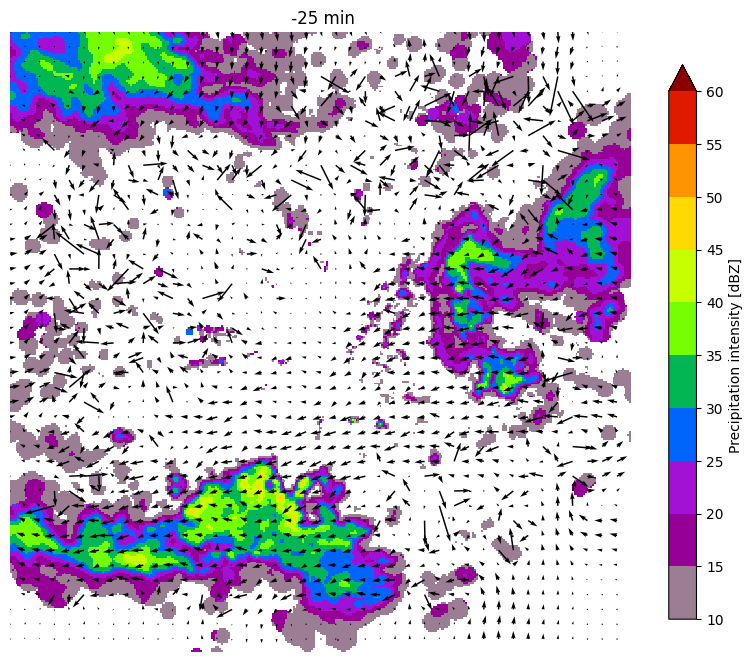

In [19]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 9))

plot_precip_field(x_lagrangian_np[0], units='dBZ')

def update(frame):
    plt.cla()
    if frame >= 6:
        plot_precip_field(nowcast_np[0][frame-6], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][frame-6], step=8)
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plot_precip_field(x_np[frame], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][0], step=8)
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

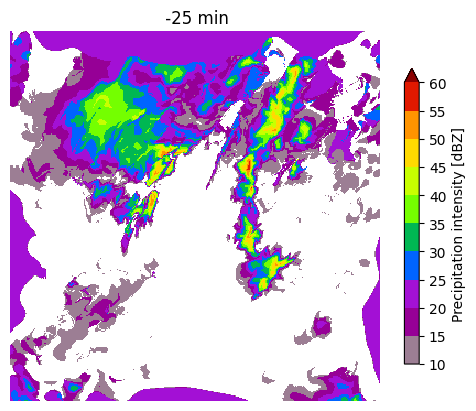

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field

fig, ax = plt.subplots()

plot_precip_field(x_lagrangian_np[0], units='dBZ')

def update(frame):
    plt.cla()
    if frame >= 6:
        plot_precip_field(nowcast_np[0][frame-6], colorbar=False, units='dBZ')
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plot_precip_field(x_lagrangian_np[frame], colorbar=False, units='dBZ')
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

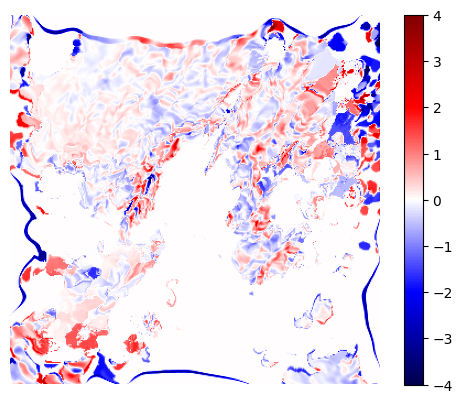

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(pred_np[0][0], cmap='seismic', vmin=-4, vmax=4)
cbar = plt.colorbar()

# x_lagrangian_diff_np[x_lagrangian_diff_np == 0] = np.nan
# y_i_np[y_i_np <= 0] = np.nan

def update(frame):
    plt.cla()
    if frame == 5:
        plt.imshow(pred_np[0][0], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    else:
        plt.imshow(x_lagrangian_diff_np[frame], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    plt.axis('off')
    # plt.title(f"{(frame-5)*5:+4d} min")
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
HTML(ani.to_jshtml())

<Axes: >

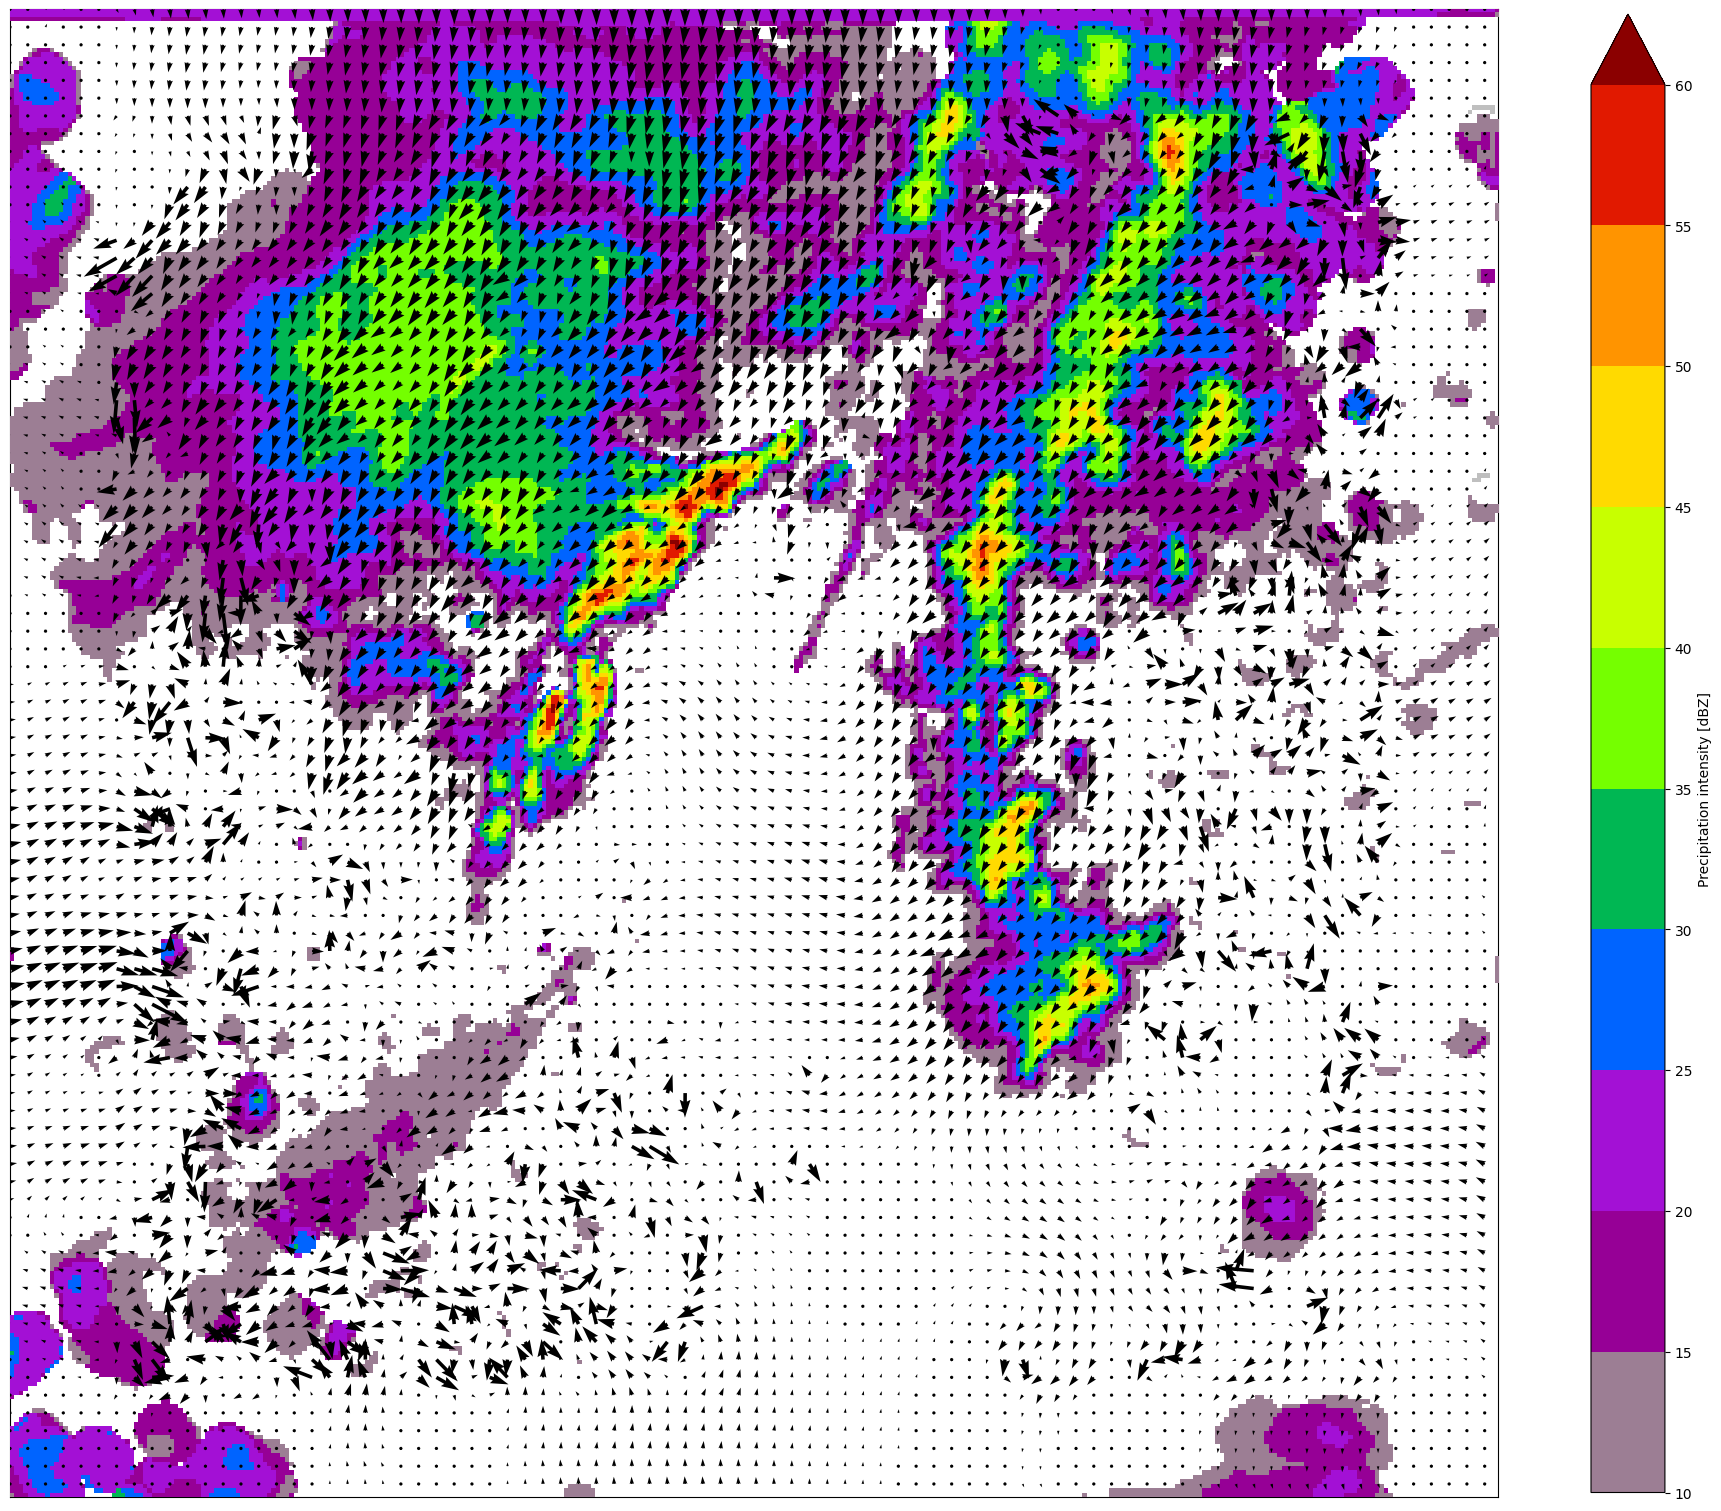

In [ ]:
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

fig, ax = plt.subplots(figsize=(24, 24))
# plt.imshow(x_np[-1], cmap='gist_ncar')
plot_precip_field(pred_total_np[0][0], ax=ax, axis="off", units="dBZ")
mf_np = mf[0].detach().cpu().numpy()
#mf_np[mf_np > 0.1] = 0.1
#mf_np[mf_np < -0.1] = -0.1
# mf_np[1] *= -1

# Plot the motion field vectors
quiver(mf_np, step=4)